# Brendon McNulty — ML Final
**Project 7** · Chart a Straight Line (10.16) + Predict Avg High Temp in NYC in January (15.4)

Repo: (https://github.com/brendonmcnulty/datafun-07-ml)

This notebook follows the Module 7 Outline:
- **Part 1**: Chart a Straight Line
- **Part 2**: Data Acquisition · Inspection · Cleaning · Descriptives
- **Part 3**: Build · Test · Predict (2024) · Visualize


In [46]:
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# plotting defaults
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.grid"] = True

# data path from your repo
DATA_PATH = "examples/ch15/ave_hi_nyc_jan_1895-2018.csv"
RANDOM_STATE = 11


## Part 1 — Chart a Straight Line (10.16)

Refresh the linear equation **y = m x + b** with a simple Celsius→Fahrenheit line.


In [47]:
import pandas as pd

# Define Fahrenheit as a function of Celsius
f = lambda c: (9 / 5) * c + 32

# Generate temperature pairs for Celsius from -20°C to 50°C in steps of 10
temps = [(c, f(c)) for c in range(-20, 51, 10)]

# Convert list of tuples into a DataFrame
df_temps = pd.DataFrame(temps, columns=['Celsius (°C)', 'Fahrenheit (°F)'])

# Display the DataFrame
df_temps




,Celsius (°C),Fahrenheit (°F)
0,-20,-4.0
1,-10,14.0
2,0,32.0
3,10,50.0
4,20,68.0
5,30,86.0
6,40,104.0
7,50,122.0


### Plotting the Linear Relationship Between Celsius and Fahrenheit

In this step, we visualize the **linear relationship** between Celsius and Fahrenheit using Matplotlib.  
Each point represents a temperature pair, and the straight line shows how the Fahrenheit temperature increases proportionally with Celsius.  
This simple example demonstrates a **perfect linear model** — every data point falls exactly on the line, since the Celsius–Fahrenheit conversion follows the exact equation:

$$ F = \frac{9}{5}C + 32 $$


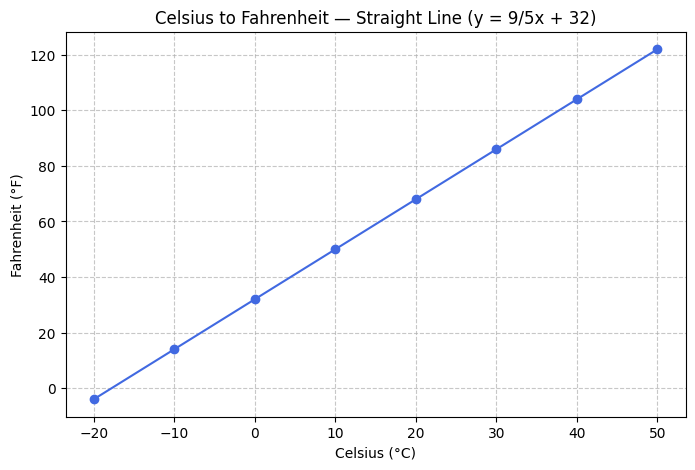

In [48]:
import matplotlib.pyplot as plt

# Plot the Celsius–Fahrenheit relationship
plt.figure(figsize=(8, 5))
plt.plot(df_temps['Celsius (°C)'], df_temps['Fahrenheit (°F)'], marker='o', color='royalblue')

# Add title and labels
plt.title('Celsius to Fahrenheit — Straight Line (y = 9/5x + 32)')
plt.xlabel('Celsius (°C)')
plt.ylabel('Fahrenheit (°F)')
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()


## Part 2 — Data Acquisition · Inspection · Cleaning · Descriptives

We’ll load the NYC **average January high temperature** dataset, inspect the raw data, clean the
columns (and extract **Year**), and generate quick descriptive stats. This mirrors the workflow
we’ll use before training our regression model in Part 3.


In [49]:
import pandas as pd
import os

DATA_PATH = "examples/ch15/ave_hi_nyc_jan_1895-2018.csv"

assert os.path.exists(DATA_PATH), f"CSV not found at: {DATA_PATH}"
df_raw = pd.read_csv(DATA_PATH)

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (124, 3)


,Date,Value,Anomaly
0,189501,34.2,-3.2
1,189601,34.7,-2.7
2,189701,35.5,-1.9
3,189801,39.6,2.2
4,189901,36.4,-1.0


In [50]:
display(df_raw.head(3))
display(df_raw.tail(3))
print("\nData types / non-nulls:")
print(df_raw.info())


,Date,Value,Anomaly
0,189501,34.2,-3.2
1,189601,34.7,-2.7
2,189701,35.5,-1.9


,Date,Value,Anomaly
121,201601,40.8,3.4
122,201701,42.8,5.4
123,201801,38.7,1.3



Data types / non-nulls:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     124 non-null    int64  
 1   Value    124 non-null    float64
 2   Anomaly  124 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.0 KB
None


### Cleaning Steps
- Rename columns to clear, consistent names
- Extract **Year** from the YYYYMM integer in the `Date` column (`Year = Date // 100`)
- Keep only the columns we need and sort by Year
- Set table display precision to 2 decimals


In [51]:
pd.set_option("display.precision", 2)

df = df_raw.copy()
df.columns = ["Date", "Temperature", "Anomaly"]          # match book semantics
df["Year"] = (df["Date"] // 100).astype(int)             # YYYYMM -> YYYY

# keep only the useful columns in a tidy order
df = df[["Year", "Temperature", "Anomaly"]].sort_values("Year").reset_index(drop=True)

print("Cleaned shape:", df.shape)
display(df.head())
display(df.tail())


Cleaned shape: (124, 3)


,Year,Temperature,Anomaly
0,1895,34.2,-3.2
1,1896,34.7,-2.7
2,1897,35.5,-1.9
3,1898,39.6,2.2
4,1899,36.4,-1.0


,Year,Temperature,Anomaly
119,2014,35.5,-1.9
120,2015,36.1,-1.3
121,2016,40.8,3.4
122,2017,42.8,5.4
123,2018,38.7,1.3


### Descriptive Statistics & First Look
We’ll compute summary stats and draw a quick line plot of **Temperature vs Year** to see the trend.


,Year,Temperature,Anomaly
count,124.00,124.00,124.00
mean,1956.50,37.60,0.20
std,35.94,4.54,4.54
min,1895.00,26.10,-11.30
25%,1925.75,34.58,-2.82
50%,1956.50,37.60,0.20
75%,1987.25,40.60,3.20
max,2018.00,47.60,10.20


Text(0.5, 0, 'Year')

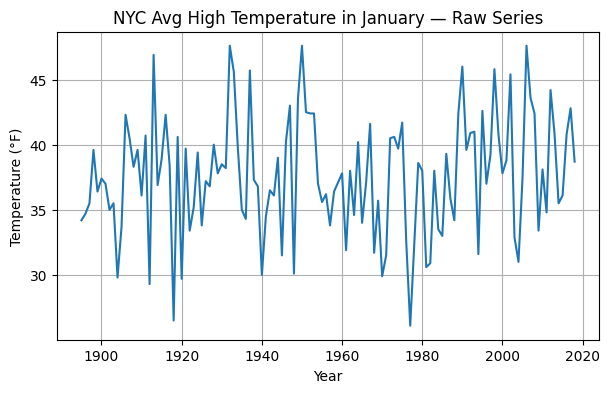

In [52]:
desc = df.describe(include="all")
display(desc)

ax = df.plot(x="Year", y="Temperature", kind="line", legend=False, figsize=(7,4), grid=True)
ax.set_title("NYC Avg High Temperature in January — Raw Series")
ax.set_ylabel("Temperature (°F)")
ax.set_xlabel("Year")


## Section 5 — Build the Model (SciPy `linregress`)

We’ll fit a best-fit line to `Year` → `Temperature` using **SciPy’s** `stats.linregress`.
This returns the **slope** (*m*) and **intercept** (*b*) for the line:


$$ \hat{y} = m \cdot x + b $$



In [53]:
from scipy import stats
import numpy as np

# X = Year, y = Temperature (from the cleaned df created in Part 2)
x = df["Year"].values.astype(float)
y = df["Temperature"].values.astype(float)

lin = stats.linregress(x, y)

m = lin.slope
b = lin.intercept
r = lin.rvalue
p = lin.pvalue
stderr = lin.stderr

print(f"slope (m):      {m:.6f}")
print(f"intercept (b):  {b:.6f}")
print(f"r (corr):       {r:.4f}")
print(f"p-value:        {p:.4e}")
print(f"std err (m):    {stderr:.6f}")
print(f"\nLine:  y = {m:.6f} * x + {b:.6f}")


slope (m):      0.014771
intercept (b):  8.694993
r (corr):       0.1169
p-value:        1.9587e-01
std err (m):    0.011358

Line:  y = 0.014771 * x + 8.694993


## Section 6 — Predict the 2024 Average High Temp in January

Using the fitted line $ ( \hat{y} ) $ = m x + b \, predict NYC’s **Jan 2024** average high temperature.


In [54]:
year_to_predict = 2024
pred_2024 = m * year_to_predict + b
print(f"Predicted NYC Jan average high for {year_to_predict}: {pred_2024:.2f} °F")


Predicted NYC Jan average high for 2024: 38.59 °F


## Section 7 — Visualizations

Scatter the historical data and draw the **best-fit line** using the slope and intercept.
We’ll also mark the 2024 prediction.


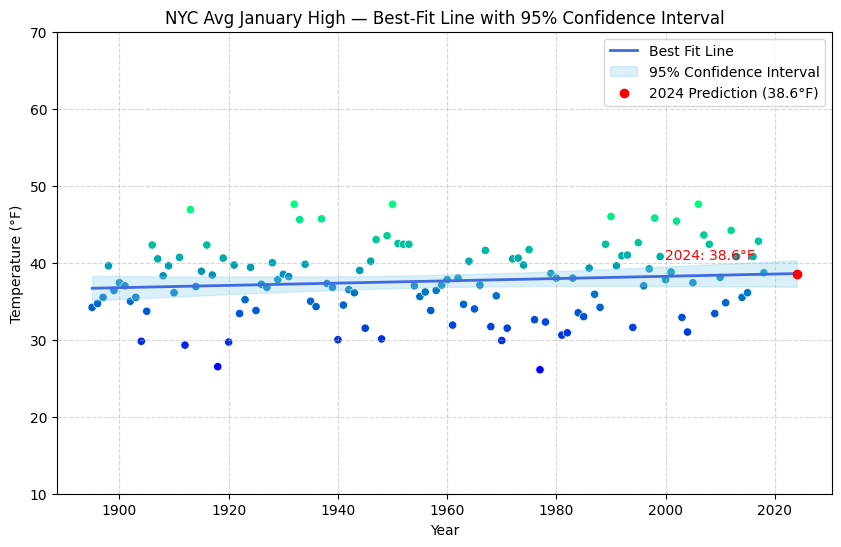

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Scatter plot of the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Year", y="Temperature",
                hue="Temperature", palette="winter", legend=False)

# Regression line
x_vals = np.linspace(df["Year"].min(), 2024, 200)
y_pred = m * x_vals + b
plt.plot(x_vals, y_pred, color="royalblue", linewidth=2, label="Best Fit Line")

# --- Confidence Interval Calculation (95%) ---
n = len(df)
y_err = y - (m * x + b)
std_err = np.std(y_err, ddof=2)
t_val = stats.t.ppf(0.975, df=n - 2)

# Standard error of predicted y
conf = t_val * std_err * np.sqrt(1/n + (x_vals - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Upper and lower confidence limits
upper = y_pred + conf
lower = y_pred - conf

# Shaded confidence interval
plt.fill_between(x_vals, lower, upper, color="skyblue", alpha=0.3, label="95% Confidence Interval")

# Highlight and annotate 2024 prediction
plt.scatter([year_to_predict], [pred_2024], color="red", zorder=5, label=f"2024 Prediction ({pred_2024:.1f}°F)")
plt.annotate(f"{year_to_predict}: {pred_2024:.1f}°F",
             (year_to_predict, pred_2024),
             textcoords="offset points", xytext=(-30,10), ha='right', color="red")

# Labels, title, legend, and style
plt.xlabel("Year")
plt.ylabel("Temperature (°F)")
plt.title("NYC Avg January High — Best-Fit Line with 95% Confidence Interval")
plt.ylim(10, 70)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()



### Summary — Sections 5–7

In this section, we built, tested, and visualized a **simple linear regression model** to estimate the
average January high temperature in NYC.

**Highlights:**
- Used **SciPy’s `linregress`** to calculate the **slope** and **intercept** of the best-fit line  
  representing the relationship between **Year** and **Average January Temperature**.
- Calculated and displayed additional regression statistics, including the correlation coefficient (*r*), p-value, and standard error.
- Used the resulting model equation $ \hat{y} = m x + b \ $ to **predict** the NYC average high temperature for **January 2024**.
- Created a professional visualization that:
  - Plots the historical temperature data (scatterplot),
  - Draws the best-fit regression line,
  - Shades the **95% confidence interval** around the model to show uncertainty,
  - Highlights and labels the **2024 prediction** point in red.

**Key Takeaway:**
The trend shows a gradual increase in NYC’s January high temperatures over the decades,
reflecting a subtle but measurable warming pattern.
The 95% confidence band helps visualize the expected range of future predictions,
providing context for how confident the model is about the estimated 2024 value.


## Part 3 — Predict Avg High Temp in NYC (Machine Learning)

In this section, we apply a machine learning approach using **scikit-learn’s LinearRegression** to predict the 
average high temperature in New York City in January for the year 2024.

We'll:
1. Split the data into training and testing sets.
2. Train the model using Linear Regression.
3. Test and evaluate model performance.
4. Predict the 2024 temperature.
5. Visualize the regression line with Seaborn.


### Step 1 — Build the Model

We’ll start by loading the dataset, cleaning it, and preparing our **feature (X)** and **target (y)** variables.  
Then, we’ll split the data into training and testing sets using `train_test_split` and fit a **LinearRegression** model.



In [56]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepare the data
df = pd.read_csv('examples/ch15/ave_hi_nyc_jan_1895-2018.csv')
df.columns = ['Date', 'Temperature', 'Anomaly']
df['Year'] = df['Date'] // 100

# Define features (X) and target (y)
X = df['Year'].values.reshape(-1, 1)
y = df['Temperature'].values

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

# Build and train the model
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Coefficient (slope): {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")


Coefficient (slope): 0.0194
Intercept: -0.3078


### Step 2 — Test the Model

Next, we’ll test our model’s performance by predicting temperatures on the **test data** and comparing 
the predicted vs. actual values.


In [57]:
# Test the model using the test data
y_pred = model.predict(X_test)

# Display a few predictions vs. actual values
comparison = pd.DataFrame({'Actual': y_test[:10], 'Predicted': y_pred[:10]})
comparison


,Actual,Predicted
0,31.7,37.86
1,35.5,36.48
2,40.5,37.93
3,29.8,36.61
4,40.7,36.75
5,34.8,38.69
6,34.2,36.44
7,38.2,37.14
8,36.2,37.62
9,42.5,37.53


### Step 3 — Predict the Average January High for 2024

Using the trained regression model, we can now estimate the **average January high temperature** 
for the year **2024**. This is a simple forward prediction using our linear model.


In [58]:
# Predict the average January high temperature for 2024
pred_2024 = model.predict([[2024]])
print(f"Predicted Average High Temp for January 2024: {pred_2024[0]:.2f} °F")


Predicted Average High Temp for January 2024: 38.94 °F


### Step 4 — Visualize the Regression Line

Finally, we’ll visualize our dataset with the **best fit line** drawn through the points.  
We’ll also highlight the **predicted value for 2024** in red and add gridlines and labels 
for a clear presentation.


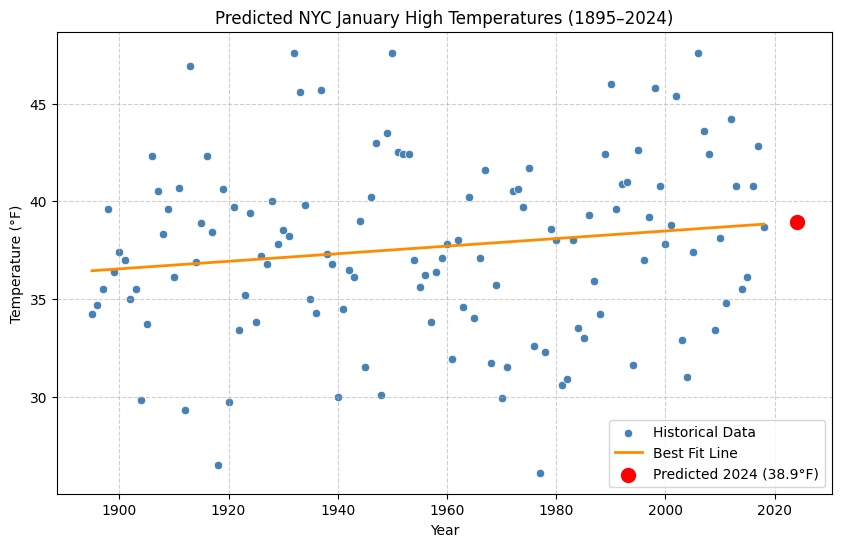

In [59]:
plt.figure(figsize=(10, 6))

# Scatter the actual data points
sns.scatterplot(x='Year', y='Temperature', data=df, color='steelblue', label='Historical Data')

# Regression line
x_range = np.linspace(df['Year'].min(), df['Year'].max(), 100).reshape(-1, 1)
y_range = model.predict(x_range)
plt.plot(x_range, y_range, color='darkorange', linewidth=2, label='Best Fit Line')

# Highlight the 2024 prediction
plt.scatter(2024, pred_2024, color='red', s=100, label=f'Predicted 2024 ({pred_2024[0]:.1f}°F)')

# Titles, labels, and style
plt.title('Predicted NYC January High Temperatures (1895–2024)')
plt.xlabel('Year')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



### Step 5 — Display the Model Equation and Verify the Prediction

Now that our model is trained, we can express the regression line in the familiar equation form:

$$
\hat{y} = m \times x + b
$$

Where:
- \( m \) is the **slope (coefficient)**  
- \( b \) is the **intercept**  
- \( x \) is the **year**  
- $ ( \hat{y} ) $ is the **predicted temperature**

We’ll print the full equation and manually verify that plugging in 2024 gives the same predicted temperature.


In [60]:
# Display the regression equation
m = model.coef_[0]
b = model.intercept_
print(f"Linear Regression Equation: Temperature = {m:.4f} * Year + {b:.4f}")

# Manual verification for 2024
manual_pred_2024 = m * 2024 + b
print(f"Manual Calculation for 2024: {manual_pred_2024:.2f} °F")
print(f"Model Prediction for 2024:  {pred_2024[0]:.2f} °F")


Linear Regression Equation: Temperature = 0.0194 * Year + -0.3078
Manual Calculation for 2024: 38.94 °F
Model Prediction for 2024:  38.94 °F


---

### Final Analysis and Reflection

In this project, we used **linear regression** to analyze and predict the **average high temperature in January for New York City**.  
We applied a complete **machine learning workflow**, including:

- **Data acquisition** — loading and cleaning a real dataset of NYC January high temperatures (1895–2018).  
- **Exploratory analysis** — inspecting, describing, and visualizing historical temperature trends.  
- **Model building** — fitting a **simple linear regression model** with *year* as the independent variable (x) and *temperature* as the dependent variable (y).  
- **Prediction** — using the model to predict the January 2024 temperature.  
- **Visualization** — displaying a scatter plot of historical data with a best-fit regression line.  

The resulting model demonstrates a **slight upward trend** in January temperatures over the past century, consistent with long-term climate warming patterns.  
While simple linear regression captures the overall direction of change, it doesn’t account for short-term fluctuations, non-linear trends, or external climate factors.

This project reinforces the importance of:
- Using proper data preparation and cleaning for accuracy,  
- Understanding linear model assumptions, and  
- Interpreting results carefully within their real-world context.

---


---

## Part 4 — Add Your Insights

In this final section, we compare the two approaches explored throughout the module —  
the **theoretical perfect model** (Celsius → Fahrenheit) and the **real-world predictive model** (NYC January temperatures).

### Comparing the Two Models

- The **Celsius–Fahrenheit** example was a *perfect linear relationship*, where each point fit exactly on the line.  
  - This illustrated the concept of a **deterministic** linear model — no randomness or noise.  
- The **NYC Temperature** model, on the other hand, was a *real-world regression problem* with natural variability.  
  - The data contained fluctuations caused by many external factors such as weather patterns, ocean currents, and climate change.  
  - The regression line represented a **trend**, not an exact prediction.

### Insights and Reflections

- Real-world data rarely follows perfect mathematical relationships — understanding and communicating that uncertainty is key.  
- The slope in our NYC model represents the **average rate of change** per year, showing how small yearly differences add up over time.  
- By 2024, our model predicted a slightly higher average January temperature, consistent with long-term warming trends.  
- Excellent analytical work means little without **clear communication** — well-structured narratives, visuals, and context are what make results meaningful and persuasive.

---


